In [ ]:
import torch
import sys
from pathlib import Path

# Add parent directory to path to import src modules
sys.path.append('..')
data_dir = Path("../")

from src.gated_kans.ae_kan_correlation import KANAutoencoderCorrelation
from src.gated_kans.gated_kan_ae import GatedKANAutoencoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device disponible: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

Device disponible: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Memory available: 6.9 GB


In [14]:
import sys
import os
import pandas as pd
sys.path.append('..')

from src.utils.yield_curve_data import load_preprocessed_yield_curve, prepare_yield_curve_for_kan

raw_dataset = pd.read_csv("../data/raw/fred_yield_curve.csv", index_col=0, parse_dates=True).drop(columns=["1M"])

df_cross_section, df_column_wise = load_preprocessed_yield_curve(
    start="1990-01-01",
    normalization="both"
)

FRED Yield Curve: 9308 rows × 8 cols
     Saved to: data\raw\fred_yield_curve.csv
Column 1M has 3020 NaNs
Dropping columns: ['1M']
Cross-section z-score shape: (9308, 7)
Column-wise z-score shape: (9308, 7)


In [15]:
df_cross_section
df_column_wise
raw_dataset

,3M,6M,1Y,2Y,5Y,10Y,30Y
DATE,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.87,7.94,8.00
1990-01-03,7.89,7.94,7.85,7.94,7.92,7.99,8.04
1990-01-04,7.84,7.90,7.82,7.92,7.91,7.98,8.04
1990-01-05,7.79,7.85,7.79,7.90,7.92,7.99,8.06
1990-01-08,7.79,7.88,7.81,7.90,7.92,8.02,8.09
...,...,...,...,...,...,...,...
2025-08-22,4.27,4.08,3.87,3.68,3.76,4.26,4.88
2025-08-25,4.29,4.08,3.88,3.73,3.80,4.28,4.89
2025-08-26,4.28,4.06,3.85,3.61,3.75,4.26,4.90


# Datasets generation

In [23]:
datasets = {}

# Dataset 1: Raw data (no normalization)
datasets['raw'] = {
    'name': 'Raw Data',
    'data': raw_dataset,
    'description': 'Original yield curve data without any normalization'
}

# Dataset 2: Cross-section normalized (each row normalized)
datasets['cross_section'] = {
    'name': 'Cross-Section Normalized',
    'data': df_cross_section,
    'description': 'Each time point normalized across tenors (rows normalized)'
}

# Dataset 3: Column-wise normalized (each tenor normalized separately)
datasets['column_wise'] = {
    'name': 'Column-Wise Normalized', 
    'data': df_column_wise,
    'description': 'Each tenor normalized separately across time (columns normalized)'
}

# Dataset 4: Z-score normalized (standardized)
df_zscore = (raw_dataset - raw_dataset.mean()) / raw_dataset.std()
datasets['zscore'] = {
    'name': 'Z-Score Normalized',
    'data': df_zscore,
    'description': 'Standardized data with mean=0 and std=1 for each tenor'
}

# Dataset 5: Min-Max scaled to [0,1]
df_minmax = (raw_dataset - raw_dataset.min()) / (raw_dataset.max() - raw_dataset.min())
datasets['minmax'] = {
    'name': 'Min-Max Scaled',
    'data': df_minmax,
    'description': 'Data scaled to range [0,1] for each tenor'
}

print(f"Created {len(datasets)} datasets:")
for key, dataset in datasets.items():
    print(f"  - {key}: {dataset['name']}")
    print(f"    Shape: {dataset['data'].shape}")
    print(f"    Description: {dataset['description']}")
    print()


Created 5 datasets:
  - raw: Raw Data
    Shape: (9303, 7)
    Description: Original yield curve data without any normalization

  - cross_section: Cross-Section Normalized
    Shape: (9308, 7)
    Description: Each time point normalized across tenors (rows normalized)

  - column_wise: Column-Wise Normalized
    Shape: (9308, 7)
    Description: Each tenor normalized separately across time (columns normalized)

  - zscore: Z-Score Normalized
    Shape: (9303, 7)
    Description: Standardized data with mean=0 and std=1 for each tenor

  - minmax: Min-Max Scaled
    Shape: (9303, 7)
    Description: Data scaled to range [0,1] for each tenor



In [24]:
# Split all datasets into train, validation and test sets
# Use time-based split since this is financial time series data

# Calculate split points 
n_samples = len(raw_dataset)
train_size = int(0.7 * n_samples)  # 70% for training
val_size = int(0.15 * n_samples)   # 15% for validation

# Split each dataset chronologically and convert to tensors
for key, dataset in datasets.items():
    data = dataset['data']
    
    # Split the data chronologically
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size+val_size] 
    test_data = data.iloc[train_size+val_size:]
    
    # Convert to tensors and add to dataset dictionary
    dataset['X_train'] = torch.tensor(train_data.values, dtype=torch.float32)
    dataset['X_val'] = torch.tensor(val_data.values, dtype=torch.float32)
    dataset['X_test'] = torch.tensor(test_data.values, dtype=torch.float32)
    
    print(f"{dataset['name']}:")
    print(f"  Training set: {len(dataset['X_train'])} samples")
    print(f"  Validation set: {len(dataset['X_val'])} samples")
    print(f"  Test set: {len(dataset['X_test'])} samples")
    print()


Raw Data:
  Training set: 6512 samples
  Validation set: 1395 samples
  Test set: 1396 samples

Cross-Section Normalized:
  Training set: 6512 samples
  Validation set: 1395 samples
  Test set: 1401 samples

Column-Wise Normalized:
  Training set: 6512 samples
  Validation set: 1395 samples
  Test set: 1401 samples

Z-Score Normalized:
  Training set: 6512 samples
  Validation set: 1395 samples
  Test set: 1396 samples

Min-Max Scaled:
  Training set: 6512 samples
  Validation set: 1395 samples
  Test set: 1396 samples



In [32]:
dataset_list = list(datasets.keys())
datasets["raw"]["X_train"]

tensor([[7.8300, 7.8900, 7.8100,  ..., 7.8700, 7.9400, 8.0000],
        [7.8900, 7.9400, 7.8500,  ..., 7.9200, 7.9900, 8.0400],
        [7.8400, 7.9000, 7.8200,  ..., 7.9100, 7.9800, 8.0400],
        ...,
        [0.0400, 0.1100, 0.2200,  ..., 1.5800, 2.1200, 2.7400],
        [0.0300, 0.1100, 0.2100,  ..., 1.5300, 2.0700, 2.6900],
        [0.0300, 0.1100, 0.2300,  ..., 1.6100, 2.1400, 2.7400]])

In [103]:
print(datasets["raw"]["X_train"].min())
print(datasets["raw"]["X_train"].max())

tensor(0.)
tensor(9.1800)


In [107]:
for i in range(7):
    print(datasets["raw"]["X_train"][:, i].mean())


tensor(3.1194)
tensor(3.2576)
tensor(3.3889)
tensor(3.7192)
tensor(4.3791)
tensor(4.9599)
tensor(5.5079)


In [89]:
from src.models.gated_kan_ae import GatedKANAutoencoder
from src.models.ae_kan import KANAutoencoder

gated_kan = KANAutoencoder(
    input_dim=raw_dataset.shape[1],
    k=3,
    hidden_dims=[5, 4],
    
    basis_type="spline",
    M=16,
    poly_degree=5,
    xmin=0,
    xmax=10,
    dropout_p=0.001,
    use_silu=True,
    
    # gate_init=0.5,
    # skip_rank=None,
    
    loss_type="huber",
    huber_delta=1,
    
    use_global_skip = False,
    use_skip = False,
    skip_init = "zeros",
    skip_gain = 0.3,
    max_skip_gain = 1,
    
    lambda_alpha=0.0001,
    lambda_group=0.00001,
    lambda_tv=0.0001,
    lambda_poly_decay=0,
    lambda_skip_l2=0.00001
    # lambda_orthogonal=0.01,
    # lambda_gate_reg=0.00001
)


In [91]:
history = gated_kan.fit(
        X=datasets["raw"]["X_train"],
        # X_val=datasets["raw"]["X_val"],
        validation_split=0.2,
        epochs=100, 
        batch_size=64,
        learning_rate=0.0001, 
        weight_decay=0,
        patience=10,
        verbose=True, 
        lambda_reg=0.1,
        # use_weighted_loss=False,
        device=device
)

📈 Epoch 1/100 | Train: 3.522415 | Val: 3.595749 ✅ | Reg: 0.000459 | LR: 1.00e-04
📈 Epoch 2/100 | Train: 3.504631 | Val: 3.582992 ✅ | Reg: 0.000516 | LR: 1.00e-04
📈 Epoch 3/100 | Train: 3.496153 | Val: 3.569248 ✅ | Reg: 0.000580 | LR: 1.00e-04
📈 Epoch 4/100 | Train: 3.479184 | Val: 3.554459 ✅ | Reg: 0.000648 | LR: 1.00e-04
📈 Epoch 5/100 | Train: 3.461451 | Val: 3.538624 ✅ | Reg: 0.000719 | LR: 1.00e-04
📈 Epoch 6/100 | Train: 3.450969 | Val: 3.521722 ✅ | Reg: 0.000791 | LR: 1.00e-04
📈 Epoch 7/100 | Train: 3.429843 | Val: 3.503721 ✅ | Reg: 0.000865 | LR: 1.00e-04
📈 Epoch 8/100 | Train: 3.414275 | Val: 3.484635 ✅ | Reg: 0.000941 | LR: 1.00e-04
📈 Epoch 9/100 | Train: 3.391667 | Val: 3.464513 ✅ | Reg: 0.001018 | LR: 1.00e-04
📈 Epoch 10/100 | Train: 3.372369 | Val: 3.443351 ✅ | Reg: 0.001096 | LR: 1.00e-04
📈 Epoch 11/100 | Train: 3.348333 | Val: 3.421172 ✅ | Reg: 0.001174 | LR: 1.00e-04
📈 Epoch 12/100 | Train: 3.331096 | Val: 3.398093 ✅ | Reg: 0.001253 | LR: 1.00e-04
📈 Epoch 13/100 | Train: 3

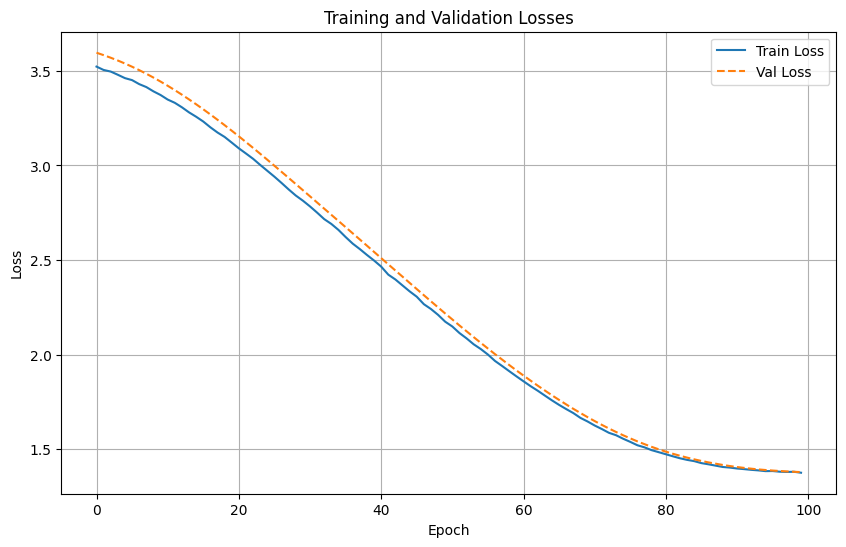

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


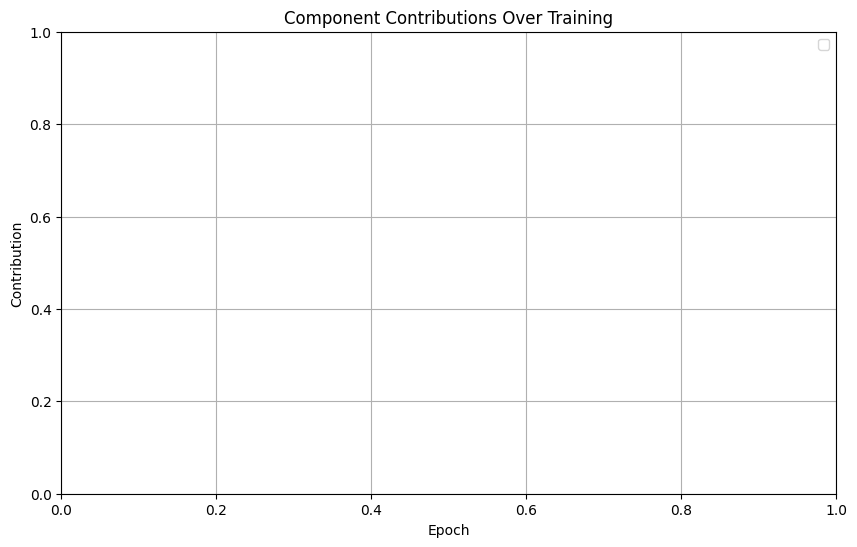

In [92]:
import matplotlib.pyplot as plt

def plot_losses(history):
    plt.figure(figsize=(10, 6))

    # Plot main losses
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], linestyle='--', label='Val Loss')

    # Plot component losses
    # plt.plot(history['reconstruction_loss'], label='Reconstruction Loss')
    # plt.plot(history['regularization_loss'], label='Regularization Loss')
    # plt.plot(history['orthogonality_loss'], label='Orthogonality Loss')

    # plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_contribution(history):
    plt.figure(figsize=(10, 6))

    # Plot gate contributions
    # plt.plot(history['kan_contribution'], label='KAN Contribution')
    # plt.plot(history['skip_contribution'], label='Skip Contribution')
    # plt.plot(history['gate_value'], color='green', label='Gate Value')  c'est égal à kan_contribution
    # plt.plot(history['orthogonality_violation'], label='Orthogonality Violation')

    plt.xlabel('Epoch')
    plt.ylabel('Contribution')
    plt.title('Component Contributions Over Training')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(history)

plot_contribution(history)

In [93]:
import numpy as np

# Encode using the model's encode method instead of .encoder
# Ensure data is on the same device as the model
device = next(gated_kan.parameters()).device
X_train_device = datasets["raw"]["X_train"].to(device)
X_test_device = datasets["raw"]["X_test"].to(device)

Z_train = gated_kan.encode(X_train_device).detach().cpu().numpy()
Z_test  = gated_kan.encode(X_test_device).detach().cpu().numpy()


In [99]:
Z_train

array([[0.4056044 , 0.07605004, 0.26445475],
       [0.4056044 , 0.07605004, 0.26445475],
       [0.4056044 , 0.07605004, 0.26445475],
       ...,
       [0.4056044 , 0.07605004, 0.26445475],
       [0.4056044 , 0.07605004, 0.26445475],
       [0.4056044 , 0.07605004, 0.26445475]], dtype=float32)

In [109]:
X_train_chapeau = gated_kan.decode(torch.tensor(Z_train)).detach().cpu().numpy()
X_test_chapeau = gated_kan.decode(torch.tensor(Z_test)).detach().cpu().numpy()

X_train_chapeau

array([[3.2832918, 3.4381342, 3.572696 , ..., 4.3527317, 4.7291155,
        5.151608 ],
       [3.2832918, 3.4381342, 3.572696 , ..., 4.3527317, 4.7291155,
        5.151608 ],
       [3.2832918, 3.4381342, 3.572696 , ..., 4.3527317, 4.7291155,
        5.151608 ],
       ...,
       [3.2832918, 3.4381342, 3.572696 , ..., 4.3527317, 4.7291155,
        5.151608 ],
       [3.2832918, 3.4381342, 3.572696 , ..., 4.352731 , 4.7291155,
        5.151608 ],
       [3.2832918, 3.4381342, 3.572696 , ..., 4.352731 , 4.7291155,
        5.151608 ]], dtype=float32)

Correlation between latent factors and principal components:
PC1: [nan nan nan]
PC2: [nan nan nan]
PC3: [nan nan nan]


c:\Users\xtrem\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xtrem\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


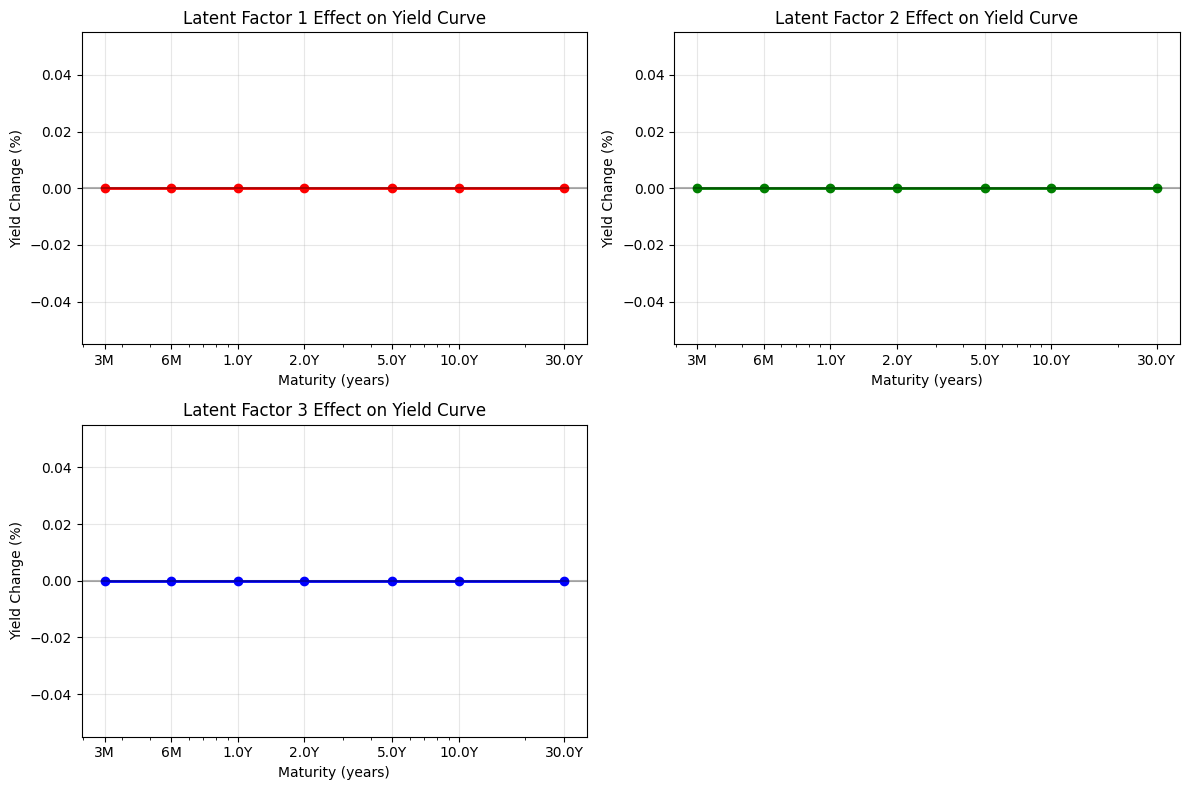

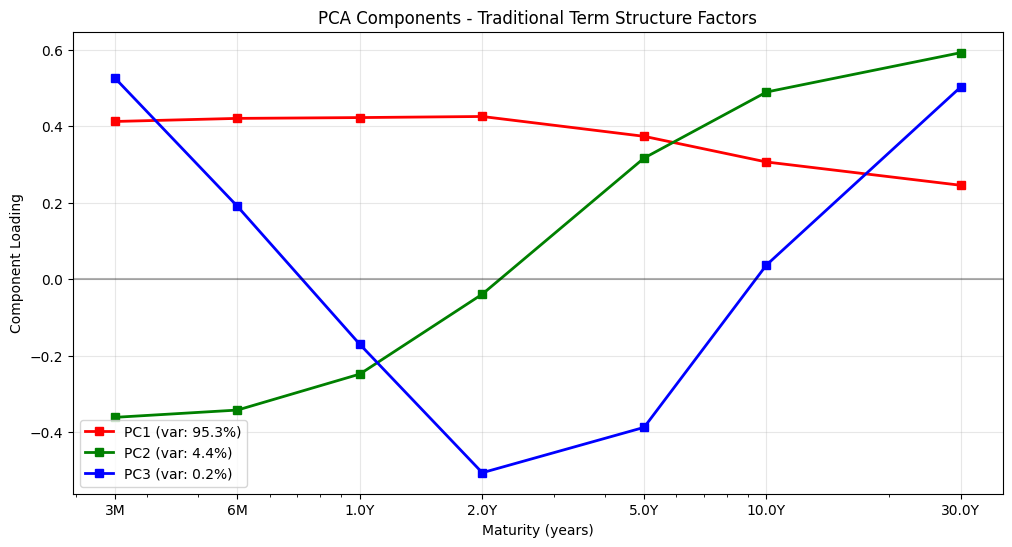


PCA Analysis Summary:
Explained variance ratio (first 3 components): [0.95329654 0.04370181 0.00226583]
Cumulative explained variance: [0.95329654 0.99699837 0.9992642 ]
Latent space dimension: 3
Original dimension: 7
5
tensor([[-0.2968, -0.1407, -0.1485,  ...,  0.6200,  1.0890,  1.5439],
        [-0.2988, -0.1428, -0.1509,  ...,  0.6176,  1.0865,  1.5413],
        [-0.2756, -0.1191, -0.1249,  ...,  0.6441,  1.1131,  1.5677],
        ...,
        [ 3.1400,  3.2806,  3.2858,  ...,  4.0765,  4.4000,  4.7023],
        [ 3.1112,  3.2515,  3.2552,  ...,  4.0454,  4.3695,  4.6726],
        [ 3.1145,  3.2548,  3.2584,  ...,  4.0486,  4.3726,  4.6754]],
       device='cuda:0')

Reconstruction Quality (MSE):
Gated KAN Autoencoder: 0.527343
PCA (3 components): 0.005000


In [56]:
# PCA baseline et analyse des facteurs latents

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure all data is on CPU for sklearn
X_train_cpu = datasets["raw"]["X_train"].cpu().numpy()
X_test_cpu = datasets["raw"]["X_test"].cpu().numpy()

# PCA analysis
pca = PCA(n_components=3)
pca.fit(X_train_cpu)
PCs_test = pca.transform(X_test_cpu)

# Correlation between latent factors and first PC
Z_test_df = pd.DataFrame(Z_test)
PCs_df = pd.DataFrame(PCs_test, columns=['PC1', 'PC2', 'PC3'])

print("Correlation between latent factors and principal components:")
for pc_idx in range(3):
    corr = Z_test_df.corrwith(PCs_df[f'PC{pc_idx+1}'], axis=0)
    print(f"PC{pc_idx+1}: {corr.values}")

# Function to compute latent factor effects
def compute_latent_effect(factor_idx: int, eps: float = 1.0) -> np.ndarray:
    """Compute the effect of perturbing a latent factor on the yield curve."""
    device = next(gated_kan.parameters()).device
    
    # Base point (zero vector)
    base_z = torch.zeros(1, Z_test.shape[1], device=device)
    
    # Get baseline reconstruction
    with torch.no_grad():
        baseline = gated_kan.decode(base_z).cpu().numpy().flatten()
    
    # Perturb the specific factor
    perturbed_z = base_z.clone()
    perturbed_z[0, factor_idx] += eps
    
    # Get perturbed reconstruction
    with torch.no_grad():
        perturbed = gated_kan.decode(perturbed_z).cpu().numpy().flatten()
    
    return perturbed - baseline

# Yield curve maturities for visualization
maturities = np.array([0.25, 0.5, 1, 2, 5, 10, 30])  # years

# Plot latent factor effects
plt.figure(figsize=(12, 8))
colors = ['red', 'green', 'blue', 'orange']

n_factors = min(Z_test.shape[1], 4)
for i in range(n_factors):
    effect = compute_latent_effect(i, eps=2.0)  # Larger perturbation for visibility
    
    plt.subplot(2, 2, i + 1)
    plt.plot(maturities, effect, color=colors[i], linewidth=2, marker='o', markersize=6)
    plt.title(f'Latent Factor {i+1} Effect on Yield Curve')
    plt.xlabel('Maturity (years)')
    plt.ylabel('Yield Change (%)')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Set x-axis to log scale for better visualization
    plt.xscale('log')
    plt.xticks(maturities, [f'{m}Y' if m >= 1 else f'{int(m*12)}M' for m in maturities])

plt.tight_layout()
plt.show()

# Compare with PCA loadings
plt.figure(figsize=(12, 6))

# Plot PCA components
for i in range(min(3, pca.components_.shape[0])):
    plt.plot(maturities, pca.components_[i], 
             color=colors[i], linewidth=2, marker='s', markersize=6,
             label=f'PC{i+1} (var: {pca.explained_variance_ratio_[i]:.1%})')

plt.title('PCA Components - Traditional Term Structure Factors')
plt.xlabel('Maturity (years)')
plt.ylabel('Component Loading')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xscale('log')
plt.xticks(maturities, [f'{m}Y' if m >= 1 else f'{int(m*12)}M' for m in maturities])
plt.show()

# Summary statistics
print(f"\nPCA Analysis Summary:")
print(f"Explained variance ratio (first 3 components): {pca.explained_variance_ratio_[:3]}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_[:3])}")
print(f"Latent space dimension: {Z_test.shape[1]}")
print(f"Original dimension: {X_test_cpu.shape[1]}")

# Reconstruction quality comparison
with torch.no_grad():
    X_test_device = datasets["raw"]["X_test"].to(next(gated_kan.parameters()).device)
    X_reconstructed = gated_kan(X_test_device)
    print(len(X_reconstructed))
    print(X_reconstructed[0])
    X_reconstructed = X_reconstructed[0].cpu().numpy()

mse_autoencoder = np.mean((X_test_cpu - X_reconstructed)**2)
X_pca_reconstructed = pca.inverse_transform(PCs_test)
mse_pca = np.mean((X_test_cpu - X_pca_reconstructed)**2)

print(f"\nReconstruction Quality (MSE):")
print(f"Gated KAN Autoencoder: {mse_autoencoder:.6f}")
print(f"PCA (3 components): {mse_pca:.6f}")
